# Preprocessing and CRIP-DM framework
This notebook is intended to guide beginning data scientists through common preprocessing steps and give them a first look at the idea behind the CRISP-DM framework: why is it important, what does it mean, how do you follow it. Each section will explain a part of the CIRSP-DM framework.

The notebook will guide the beginning data scientist through common exploration and preprocessing steps on a dataset. Some modelling will be involved, but only as a guide to make the correct preprocessing choices. Read every step carefully, as you will be asked to expand on them yourself at the end of this session.

As an exercise, we will be doing a common regression problem: predicting the price of a house.

![CrispDM.png](Figures/CrispDM.png)

Throughout the notebook, you will find `#TODO`'s and variables in capital letters. These are "arbitrary" choices that you can make during preprocessing; they might have an influence, but at this stage of processing, it is impossible to know. Only experience and the data scientists hunch/educated guess could give an indication.

When you have finished the initial steps, you should go back to these TODO's and variables and change them a bit, to see how it influences the performance of the model.

# 1. Business understanding

This is the time to reflect on the potential business value this project has. What can you achieve by being able to predict the price of a house using machine learning? In which scenario could this be useful? How would you sell this as a product? These questions can be very important when assessing the value of a model like this. Good business understanding leads to better data, better performance, and a model that integrates well with the business model (e.g. do you intend to sell the model as a whole, or just the predictions? Or perhaps a recommendation based on your own predictions?) 

You can see that this part of the CRISP-DM model also has arrows pointing towards data understanding and away from evaluation. This means that your business understanding can (and should) influence your data understanding. How you interpret the data often depends on how knowledgeable you are in the business. Seeing some initial patterns in the data also influences how you understand your business.

The same holds true for the interaction between evaluation and business understanding. When evaluating your model, you may have a good performance, giving you a market advantage, or yielding valuable insights. Yielding a low performance can also be a great lesson; is the project even sensible or possible?

![Business Understanding](Figures/BUsinessUnderstanding.png)

# 2. Data Understanding
Let's move on to the second step of the CRISP-DM framework: Data Understanding. In this step, we will be exploring the dataset: understanding the types and values, spotting outliers or weird things, taking a look at the features and what they mean...

![Data Understanding](Figures/Data-Understanding.png)

To start, we will use the dataset "California housing". This contains the average sale price of a house in a district based on a set of **features** within that district, such as the average number of bedrooms, the population and median income of the neighborhood etc... In machine learning, a feature is a piece of info that you have on a data instance. Since most tabular data show the instances as rows, and the features as columns, you can consider features as just the column name of some dataset. This analogy breaks down as soon as you transpose or pivot a table, of course.

This is a very good dataset, which hardly ever is the case in real life. That's why we're also going to artificially delete some values by replacing them with missing values (NaN) to show how to handle these later on.

Making your own methods (also commonly called functions) in Python can be done with a `def` statement, followed by the name of your function and brackets. Inside the brackets, you say which arguments the function needs (the input). You can use the names of these arguments in the functions to do various operations inside the function. The output of the function is then provided at the end with a `return` statement. The explanation of the function is given right beneath its name, between a pair of triple quotation marks `"""`. This is called the docstring of a function. It's good coding practice to include this, in order to make your code more readable to anyone who didn't write it, but also to yourself.

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing

def add_random_missing_values(df_, n_missing=8000):
  """
  Takes a pd.DataFrame :arg:`df`, selects some random rows, and
  randomly removes some values

  Args:
  df: the pandas dataframe
  n_missing: (optional) amount of missing values to fill in total. Default=8000

  Returns:
  The same dataframe, but with random missing values

  """
  rows = np.random.randint(0, len(df_) + 1, n_missing)
  # let's make it so some features have more missing values than others
  cols = [int(e) for e in
          5 * (np.random.randint(1, len(df_.columns) + 1, n_missing) + 1) / 8
          ]
  # cols is now a series of random numbers that are more dense around some value
  for r, c in zip(rows, cols):
    df_.iloc[r, c] = np.nan  # set random value to NaN
  return df_

def get_dataset(n_missing=8000):
  """
  Wrapper function to load the dataset california housing, casting it to a 
  pd.DataFrame and splitting it to data and target variable.
  The description of the dataset is also returned as a separate variable: descr
  This description is loaded when calling the function 
  fetch_california_housing()

  Args:
  n_missing: (optional) amount of values to set to NaN in the dataset. Only used 
  to pass to :func:`add_random_missing_values`

  Returns:
  X, y, descr: the data as a dataframe, the target variable as an array, the 
  description of the dataset
  """
  housing = fetch_california_housing()  # fetch the dataset
  # Extract the data, feature names and the target variable values
  data, column_names, target = housing.data, housing.feature_names, housing.target
  descr_ = housing.DESCR
  X_ = pd.DataFrame(data=data, columns=column_names)  # convert to pandas dataframe
  y_ = target  # target variable
  # Let's create some random missing values, for the sake of the exercise
  X_ = add_random_missing_values(X_, n_missing)
  return X_, y_, descr_

In [2]:
SEED = 42  # set random seed for reproducibility
np.random.seed(SEED)

X, y, descr = get_dataset()
print("################# Description of the data #################")
print(f"\n{descr}\n")

df = X
df_with_target_variable = X.assign(SalesPrice = y)  # temporarily add target variable for overview
print("\n################# Size of the data #################")
print(f"Dataset has {len(X.columns)} features and {len(X)} entries\n")

print("\n################# Tabular view of the data #################")
print(df_with_target_variable)
print("\n################# Info on the data #################")
print(df_with_target_variable.info())
print("\n################# Statistical description of the data #################")
df_with_target_variable.describe()

################# Description of the data #################

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds 

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,SalesPrice
count,20640.000000,18722.000000,19707.000000,18701.000000,19710.000000,18703.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.675729,5.429917,1.097396,1424.070066,3.059667,35.631861,-119.569704,2.068558
std,1.899822,12.575915,2.487130,0.487164,1129.721175,10.277648,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.441980,1.005865,788.000000,2.430150,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.228571,1.048338,1166.000000,2.818182,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.049101,1.099338,1724.000000,3.282264,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


We now have a dataset with features (columns) and a target variable for each entry (row). Keep in mind that, by loading the dataset, it is immediately split into X (data) and y (target). Each machine learning project should immediately split the target variable from the data to avoid leakage. Only the training set is allowed to acces info on the target variable (for e.g. WOE encoding).

## 2.1 Train and test set

A predictive machine learning project will always need a training set and a test set. It is wise to do this as soon as possible, to avoid accidental data leakage. This is why we're doing this now, as soon as we have loaded the data.

A **training set** is intended to guide a machine learning model through the training process. This training set will teach the model when it is making correct decisions, and when it is making mistakes. The ML model thus needs to know what the target variable of the training data is, in order to figure out if it is doing a good job or not. THis is exactly what "training" means.

The purpose of **the test set** may sound similar, but it is actually different. The test set is intended for the *data scientist* to check if the model is *actually* doing a good job. The test set is a dataset where the ML model has no idea what the target variable is, but the data scientist does. You can consider the test set as a sort of exam, where the ML model is supposed to guess the answers (target variable) of the test set correctly based on what it learned during the training session, and only the data scientist can assess the performance of an ML model, since it knows the target variable values.

Let's not confuse the test set either with the **prediction set**. In a test set, the data scientist knows the value of the target variable, and uses this to assess the performance of a ML model beyond the training/fitting accuracy ,i.e. the accuracy on the training set, which is very biased, since the model is simultaneously using this to adapt its inner workings. 
In a prediction set, the target variable is truly unkown, even for the data scientist. Often, the true label of the prediction set becomes known after some time (e.g. if a house gets sold after a couple of years). Sometimes, the true label is never known. This makes it all the more important to take good care of your test set.

<img src="Figures/splitting-data.png" alt="drawing" width="600"/>


Why do we need a test set? A test set is intended to check if the model can generalise beyond what it has seen. A ML model might learn a lot from a dataset and eventually predict every target of the training set with high accuracy, but that does not mean that it can do the same for new, unseen instances. With a test set, we pretend to have unseen instances, at least as far as the ML model knows. Hopefully, actually new and unseen instances will look somewhat like the test set.
For some projects, this assumption is not true, especially if the data tends to change over time. It is not uncommon for credit scoring data to change over time, just like the economic landscape does. If the prediction instances become increasingly different from the test instances over time, the performance of the ML model will drop (since it's performance was assessed on the test set in the first place).


---


Let's split the data into a training set and a test set. We will do a randomized splitting into train and test, just like in the image. Other methods are also possible, such as just selecting the last 33% of the rows, or Out-Of-Time folds, where you keep the newest data as a test set.

In [3]:
from sklearn.model_selection import train_test_split

TEST_SIZE = .33  # TODO: how much training data is optimal for the model?
RANDOM_SEED = 42  # Don't change this!

# Randomly select rows for train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_SEED)

Here, we have chosen for a test set size of .33. This means that 33% of the entire dataset will be used to test the ML model's generalising capabilities. The other 67% will be used to train the ML model. This is right now a random choice. Ideally, you want to train a model until it's fitted well enough to the training data, but not more. We'll come back to this later on.

## 2.2 Exploring the dataset
It is time to further explore the dataset. In the following section, we will make some plots to see the distribution of the training set and the training target variable.

Notice how we first split the dataset, and only then start to make exploratory plots. This is to avoid data leakage. If we would explore the entire dataset (training + test), and make our processing choices based on this (e.g. by filling missing values with the mean or mode), then the ML model would technically already know some things about the test set. THis means that the test set isn't actually "unseen" for the model. Not entirely at least.

### Distribution of the target variable
Let's start by looking at the target variable. How is the housing price in Ames distributed? We're going to use the `seaborn.histplot` module to make plots, as this is very easy to code, but you may use any plotting module you like. Perhaps you prefer `matplotlib.pyplot`

Train target variable has a skewness of 0.9860974995921904


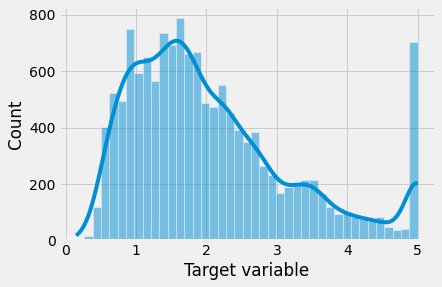

In [7]:
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats # for some statistics
plt.style.use('fivethirtyeight')  # This makes plots look neater. Just a personal preference
ax = sb.histplot(y_train,  # the target variables
                 kde=True  # show a smooth trend line
                 )
ax.set_xlabel("Target variable")
skewness = stats.skew(y_train)
print("Train target variable has a skewness of {}".format(skewness))

Three things already stand out


1.   The distribution is relatively well-behaved (skewness is about 1: a modest tail towards larger values)
2.   There seems to be a spike around 5: a very suspicious spike. The distribution drops slowly until 5, except for this spike.
3.   The prices have already been scaled, as they range from 0 to **exactly** 500k. Likely, this dataset has already been processed a bit, and values were winsorized so as to not exceed 500k (hence the spike). If this is to be the case, we could interpret all values of 5 as "500k or higher".

For now, we will leave this distribution like it is. Later on, we can check if scaling this could be beneficial.

### Description and distribution of the features
Let's take a closer look at the features. Which features are present and what do they mean? Their names are luckily very self-explanatory

*   Longitude
*   Latitude
*   Housing median age
*   Total bedrooms
*   Total rooms
*   Population
*   Households
*   Median income
*   Median house value
*   Ocean proximity

What were the meanings of the features again? Let's reprint the descriptions, so that we know later on how to process them.

In [8]:
print(descr)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

Since all the potentially ordinal variables have been aggregated (medians, averages), all of the features are continuous.

Let's take a look at the distribution of the features. Let's first check for missing values.

In [9]:
print(df.info())  # general info, already shows missing values in Non-Null Count
print(pd.DataFrame(df.isna().any(), columns=["Missing values?"]))  # shows if at least one value is NaN in each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    18722 non-null  float64
 2   AveRooms    19707 non-null  float64
 3   AveBedrms   18701 non-null  float64
 4   Population  19710 non-null  float64
 5   AveOccup    18703 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB
None
            Missing values?
MedInc                False
HouseAge               True
AveRooms               True
AveBedrms              True
Population             True
AveOccup               True
Latitude              False
Longitude             False


Now, we're going to make a distribution plots just like before, but this time for all the features.

In [10]:
def plot_distribution_of_features(X_):
  """
  A function that takes a dataset in pd.DataFrame format and plots out
  a distribution of each column. Also calculates the skewness.
  Only tested for continuous variables. Will probably need to be adapted
  for categorical variables (just change histplot to barplot)

  Args:
  X: pd.DataFrame: the dataframe

  Returns: 0 if success
  """
  for feature_name in X_:  # loop over the names of the columns
    values = X_[feature_name]  # get the values of the feature
    skewness_ = stats.skew(values, nan_policy="omit")  # while we're at it, calculate the skewness as well
    ax_ = sb.histplot(values,  # the target variables
                      kde=True  # show a smooth trend line
                      )
    ax_.set_xlabel(feature_name)
    ax_.get_figure().suptitle("Skewness of {} = {:.2f}".format(feature_name, skewness_))
    plt.show()
  return 0

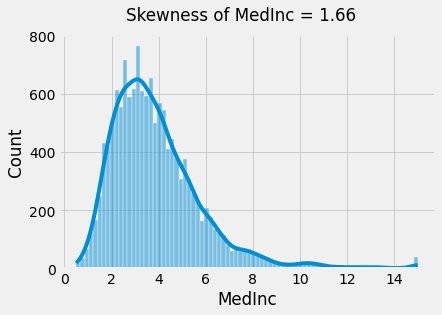

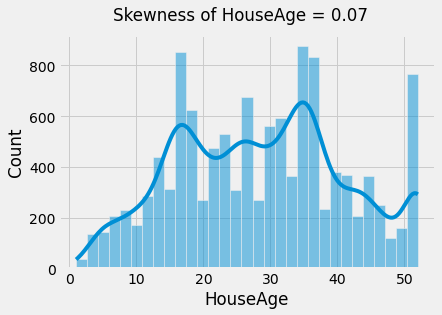

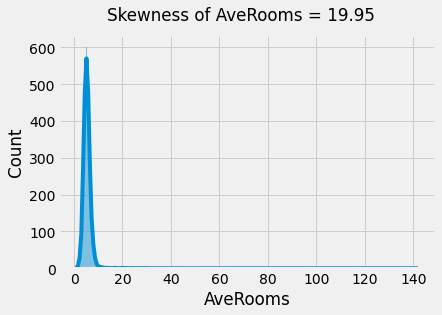

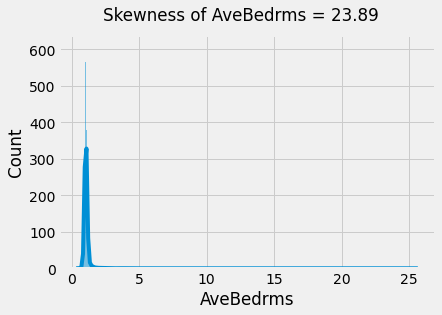

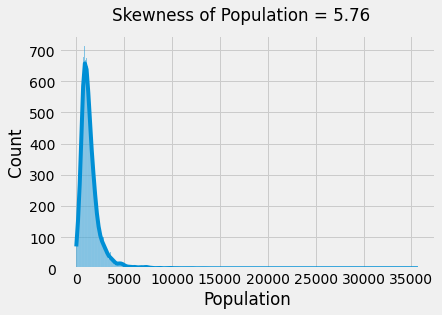

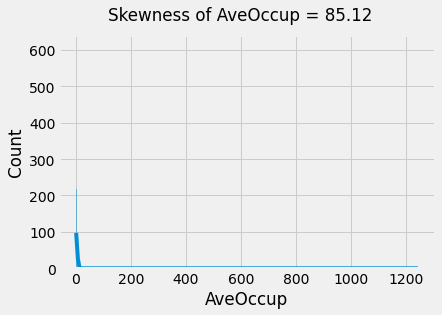

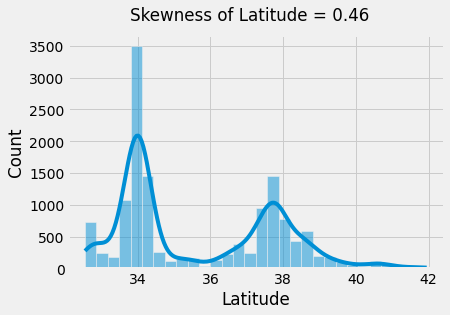

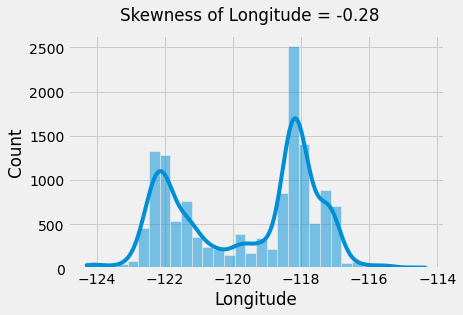

0

In [11]:
plot_distribution_of_features(X_train)

Oh la la, that's something different.
Most of these features are pretty skewed, with skewnesses around 20 (e.g. "AveBedrms" and "AveRooms"). "AveOccup" even has a skewness of over 80!

# 3. Data Preparation
Now that we have an idea what the data means, we should be able to process it accordingly

![Data Preparation](Figures/Data-Preparation.png)

Let's re-iterate what we learned in the previous secion "Data understanding"
- all variables are continuous variables
- some missing values are present, but not in all columns
- most features have very to extremely skewed values
- target variable has probably been preprocessed already

Let's delve into preprocessing these features. Note that all these features are continuous, so we don't have to encode anything (you still can if you want though, e.g. thermometer encoding).

You can process the data by applying functions directly to the pandas DataFrame, and if you're already confident with Python, you can write these functions yourself. You will run into some trouble later on though, since you have to remember all the variables defining the data transformation in order to process the test set in the same way. If, for example, you want to standardize some feature (substracting the mean and dividing by the standard deviation), then you need to remember the mean and standard deviation for that feature. This gets complicated if you want to do this for a lot of features...

You should **not** process the train and test set all at once either, since then you have data leakage: information on the test data is used to scale the training data, giving the ML model some info on the test data and skewing its performance result. Test data should resemble unseen data as much as possible to properly asses an ML model.

To fix this, we will use the full power of the `sklearn` modue. `sklearn` is a Python module, which means that it just contains a whole bunch of profesionally coded methods and classes and a whole bunch of useful stuff. What's of interest right now are the built-in scalers and column transformers: an `sklearn` `Pipeline`! A pipeline is a collection of scalers/data transformers, and predictive models. You can then fit the whole pipeline to your data. The Pipeline will take care of all of the following:
- Remember all the statistics needed for correct data transformations (i.e. fitting the data transformers)
- Fit the machine learning model to the data

Just like a prediction model, these pipelines of scalers can be fitted to the data, and the fitted transformers can be used to scale the test data in the same way as the training data. E.g. if you z-score a column, the built-in `scaler` method called `fit_transform()` will fit the scaler to the training data, transform it in the meantime, and save the mean and standard deviation of the training data to the `scaler`. The pipelines built-in `transform()` method can then be used to scale the test data, using the same mean and standard deviation as the training data. This way, no information on the distribution of the test data is used to process the training data, and the test data is scaled as well.

![fit-transform](Figures/fit_transform.png)

> Sidenote: an sklearn Pipeline is not a method, but it is a class. A class in Python can be interpreted as a "thing" that has attributes. These attributes can be static values, but also methods. This means that each "thing" has properties, and can do things. Example: a "dog" class can have an attribute like `eye_color = "brown"` and a method like `wag_tail(excitement_level=3)` that decides if the dog will wag, depending on how excited it is. This does not mean that all dogs have the same eye color, but all of them do have **some** eye color.

In [12]:
# Let's define a maximum acceptable skewness
MAX_SKEW = 1.

def get_skewed_cols(df_):
    skewness_ = df_.skew(axis=0, skipna=True, numeric_only=True).sort_values(ascending=False) \
        .to_frame(name='skew').reset_index()
    SKEWED_COLS_ = skewness_[abs(skewness_['skew']) >= MAX_SKEW]['index'].values
    return SKEWED_COLS_

SKEWED_COLS = get_skewed_cols(X_train)
NON_SKEWED_COLS = [e for e in X_train.columns if e not in SKEWED_COLS]
print(SKEWED_COLS)
print(NON_SKEWED_COLS)

['AveOccup' 'AveBedrms' 'AveRooms' 'Population' 'MedInc']
['HouseAge', 'Latitude', 'Longitude']


Let's build a Pipeline that we will use to scale the skewed columns to a normal distribution.

You can add as much scalers/imputers/... as you want to one pipeline. Each pipeline is going to be applied to a set of columns, in order. Make sure you create separate pipelines, depending on what you want to achieve. E.g.: one pipeline for continuous variables and one for categoricals; or a separate pipeline for features where missing values means the maximum (different imputer); or a different pipeline for columns where missing values means zero; a separate pipeline for one-hot encoding and a separate one for thermometer encoding ...

In [22]:
from sklearn.pipeline import Pipeline  # not sklearn.pipeline, as this one can't work with oversampling
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.compose import ColumnTransformer
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
from sklearn.impute import SimpleImputer
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
from sklearn.preprocessing import QuantileTransformer # and e.g. OneHotEncoder for categoricals
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html

skewed_pipeline = Pipeline([
    # Fills in mean where it finds missing values
    ("imputer", SimpleImputer(strategy="mean")),
    # and tries to scale to a normal distribution with QuantileTransformer()
    ("scaler", QuantileTransformer(output_distribution='normal'))
])

rest_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean"))
])

# A collection of your pipelines, with the columns they need to be applied to
preprocessing_transformers = ColumnTransformer(transformers=[
    # ('name of transformation', the Pipeline, [columns to apply to])
    ('rectify_skewed_cols', skewed_pipeline, SKEWED_COLS),  # define some name of the pipeline, pass the pipeline and an array of columns to apply it to
    ('fill_nan_w_mean', rest_pipeline, NON_SKEWED_COLS)
])  # full preprocessing pipeline

####################################################
# TODO: improve and expand these preprocessing steps

ImportError: cannot import name '_is_pandas_na' from 'sklearn.utils' (/home/bjorge/.virtualenvs/UA/lib/python3.8/site-packages/sklearn/utils/__init__.py)

Now let's fit this Pipeline to the training data and transform both training and test data.

Make sure you only apply this pipeline to the relevant columns. In our case: just the skewed columns.

In [20]:
X_train_proc = preprocessing_transformers.fit_transform(X_train, y_train)
# preprocessing_transformers is now fitted to the training data
# and remembered all transformation parameters
# Now transform test set with the same transformer
X_test_proc = preprocessing_transformers.transform(X_test)
# for the test set, use transform(), NOT fit_transform() (this will fit to the test set, which we do not want!)

# re-add column names; not obligated, but useful for inspecting the data later on
X_train_proc = pd.DataFrame(data=X_train_proc, columns=X_train.columns)
X_test_proc = pd.DataFrame(data=X_test_proc, columns=X_test.columns)

Let's see what difference this made by re-plotting the processed features

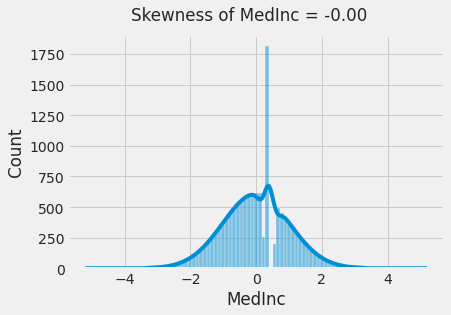

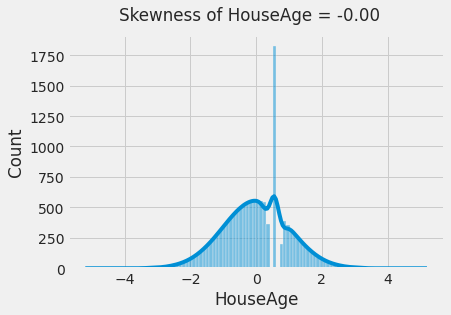

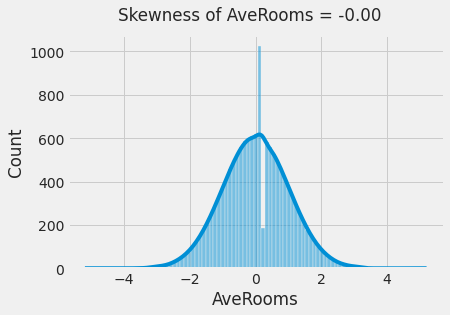

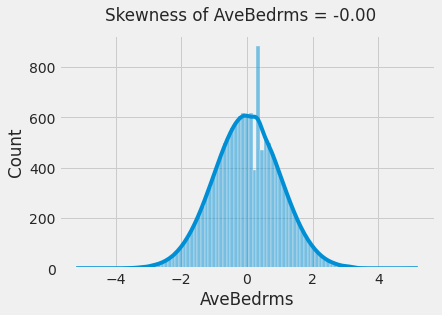

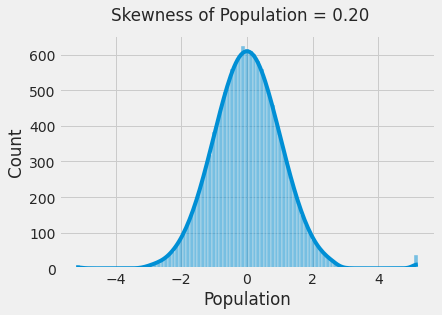

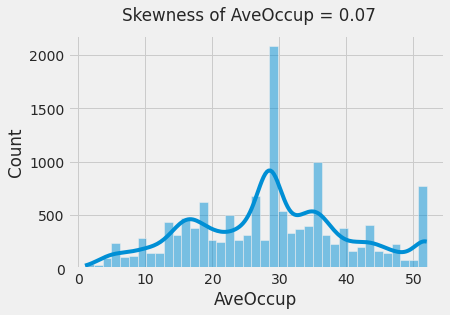

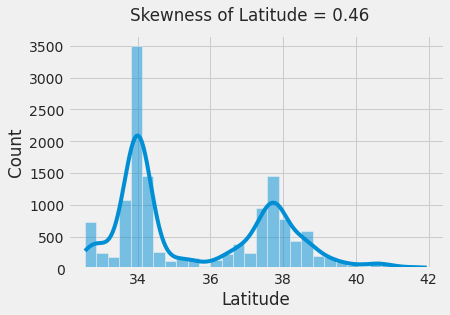

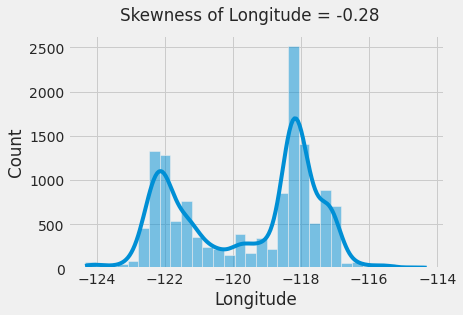

0

In [21]:
plot_distribution_of_features(X_train_proc)

This looks better! All skewed columns have a nice normal-ish distribution. Some have spikes, which is inevitable, as they are not actual normal distributions, but scaled to resemble these. For now, this suffices. We will improve this preprocessing later on, but before we know if we are doing a good job, we need a model as well.

Let's continue with modelling, and revisit the processing afterwards.

# 4. Modeling
We're going to start by building a simple model, with basic hyperparameter tuning. It's not wise to immediately spend a lot of time on modelling in this stage. Right now, we just want a model that can calculate the predictive performance with an AUC score. Then, we're gonna go back to our previous processing steps and see if some choices improve this score or not, and if the choices we have made so far are ok.


![Modeling](Figures/Data-Modeling.png)

But why stop at 1 model? With `sklearn` it's easy to train multiple at once.

Let's define some models and their hyperparameter grid. For each model, we will tune the hyperparameter using [K-fold cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) on the test set. K-fold cross validations splits the training set in a number of subsections (called the folds, the number equals k, hence the name). and always uses k-1 subsections to train, and the other one to evaluate. This is a way of sneaking in some sort of test set within the training set (confusing, i know). This is done because an evaluation on unseen data is always more accurate and less biased than evaluating on data that was used to train the model.

The only reason we're training hyperparameters now is to create a model that fits the data **sufficiently well**, so that we can use it to asses further choices during preprocessing. The model doesn't have to be a great fit, just an ok one.

To see which parameters you can tweak, take a look at the documentation of each model (provided under the `import` statements)

In [22]:
from sklearn.ensemble import RandomForestRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
# https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-regression
from sklearn.tree import DecisionTreeRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


MODELS = {
    'dt': DecisionTreeRegressor,
    'knn': KNeighborsRegressor,
    'rf': RandomForestRegressor,
    'lr': LinearRegression
}  # A dictionary with the machine learning models, 
# with a shorthand name as keys to make it easier later on

# don't try to adapt every parameter just yet, we just want a variety of 
# decent models, not perfect ones
HYPERPARAM = {
    "rf": {"n_estimators": [100, 200, 500],
           "max_depth": [70],
           "min_samples_split": [2],
           "random_state": [42]
           },
    "knn": {"n_neighbors": [10, 20, 50]
           },
    "dt": {"min_samples_leaf":[2, 5, 10],
           "criterion": ["squared_error", "absolute_error"],
           "max_depth": [70],
           "min_samples_split": [2]
           },
    "lr": {"normalize": [True, False]
           }
}  # the same shorthand names as keys, and the parameter grids as values.

################################################
# TODO: improve these models after you are satisfied with the preprocessing

Now, let's fit the models using 5-fold cross-validation.

In [23]:
from sklearn.model_selection import KFold, GridSearchCV

for model_name in MODELS.keys():  # iterate al the model shorthand names
    print(f"Fitting model: {model_name}")
    # both the model and its hyperparameter grid can be accessed via the shorthand names
    param_grid = HYPERPARAM[model_name]
    # Take the model from the MODELS dictionary and initialise them by adding brackets: ()
    # The model is now initialised with default values
    # You can also pass hyperparameter values inside the brackets: useful for later on
    model_unfitted = MODELS[model_name]()
    # Use RandomSearchCV if GridSearchCV takes too long
    gs = GridSearchCV(model_unfitted, 
                      param_grid,
                      cv=KFold(5, random_state=RANDOM_SEED, shuffle=True),  # 5-fold cross-validation
                      n_jobs=-1, # use all available processors for speeding thing up
                      verbose=3, # how much output you want during fitting (3 is more output, 1 is less)
                      scoring="r2"  # use R squared scoring for regression
                      )
    # Fit all versions of the model with GridSearchCV, i.e. hyperparameter tuning
    gs.fit(X_train_proc, y_train)  
    score = gs.score(X_test_proc, y_test)  # calculate the score on the test set
    pd.DataFrame(gs.cv_results_).to_csv("{}.csv".format(model_name))  # save the model to inspect later on
    m = gs.best_estimator_
    print(f"Best model: {m}\nR2 score: {score}\n")

########################################################
# TODO: Improve data processing pipeline, check influence on performance
# TODO: improve modeling

Fitting model: dt
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best model: DecisionTreeRegressor(max_depth=70, min_samples_leaf=10)
R2 score: 0.7182902499758169

Fitting model: knn
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best model: KNeighborsRegressor(n_neighbors=10)
R2 score: 0.6766356707466771

Fitting model: rf
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best model: RandomForestRegressor(max_depth=70, n_estimators=500, random_state=42)
R2 score: 0.8072949829470385



Note that it's important to report the test score, not the training score. The training score gives you an idea of how well the model is fitted to the seen data. The test score is the only score that gives an indication on how well it will perform on "unseen" data. This is the only score that really matters.

# 5. The flow of CRISP-DM and ML pipeline development
The CRISP-DM framework has returning arrows, indicating that you should go back on your steps.

We will focus specifically on the arrows between "Data Preparation" and "Modeling"

![prep-modeling](Figures/Prep-Modeling-Flow.png)

You now have about 3 models that are moderately fitted to your data, and a very basic data processing. Check in the output of the previous coding cell which hyperparameters were optimal for each model in the current data processing, and set these in the HYPERPARAM variable. This way, fitting will be much quicker, since it doesn't have to iterate all parameter combinations.

Now is the time to return to the previous coding with preprocessing steps and check if the choices I made were actually good choices, and if some other choices might improve the score. Some choices might be good for one model, but bad for another. This is where your business understanding can also shine. [Check out the documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) of `sklearn` to see which transformers are available, and apply them accordingly. Make sure you check for each choice if it actually improved the **score on the test set**.


---

Scroll back up and work your way through the `TODO`s. Start with the cell where we defined the Pipelines and Columntransformer and expand upon them. Work your way down through the `TODO`s and back up if you get better ideas. You will never be able to try every single combination of ideas, so stick to the ones that seem to work better in terms of test score.

Things you can try:

1.   Add/remove columns from the QuantileTransformer, so that you don't use the same transformer on all columns
2.   Try different transformers! Check the documentation to see which ones are available.
3.   Find better ways to handle missing values than imputing the mean.
4.   Try different sizes for train-test split, to see if the model isn't overfitting for example
5.   I split the columns into skewed and non-skewed columns. Maybe this wasn't necessary at all? Test it out!
6.   ... Be inventive! 





---

By now, you should have improved your data processing, and iterated upon a good way of going about processing. Your model is still badly tuned, however. We only tuned it once, and on badly processed data.

Go back to the `HYPERPARAMETER` variable and re-tune your hyperparameters. Feel free to add other regression models to the list as well; you don't need to limit yourself to just the three I added. These were just examples (although a random forest is quite powerful). Check the documentation (e.g. the [linear regressors](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) or the [ensemble methods](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble), as long as they are **regressors**) to see which models are available.

# 6. Evaluation

How much did this improve the score? How much did better processing techniques improve the score? What was your initial score, and what changed it the most?

Note down your final model, its hyperparameters, and the processing steps you took. Also not down the score the model got on the **test set**.

This was a regression exercise, but you can also extend this to classification tasks (e.g. credit scoring). For this, all you need to do is use classification models instead of regression models, and use a classification score such as F2 or ROC AUC. Likely, the preprocessing steps will also be different when iterating on a good score.

In [27]:
"""
During the training, we saved the model statistics to a csv file. Feel free to inspect it again and note down the results here.
Each .csv contains a different version of each model, where each version used different hyperparameters.

Best model:
Hyperparameters:
r2 test score:

Preprocessing steps:







"""

'\nDuring the training, we saved the model statistics to a csv file. Feel free to inspect it again and note down the results here.\n\nBest model:\nHyperparameters:\nr2 test score:\n\nPreprocessing steps:\n-\n-\n-\n- ...\n\n\n'

![evaluation](Figures/Evaluation.png)

# 7. Deployment
If you are happy with your resulting data processing pipeline and predictive model, you could now deploy your model.

How will you check if your model performs well in real life? What will you do to keep this performance up? Be sure to understand how these questions also relate to the ML-Ops framework.

This is important to think about, but lies beyond the scope of this exercise. 

**Great job, you have built your very first machine learning pipeline!**

![MLOps](Figures/MLOps-Cycle.png)